In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import optuna

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import kelbow_visualizer, silhouette_visualizer

from utils import (
    create_interactive_pie_charts,
    plot_feature_correlations,
    plot_feature_distributions,
    detection_outlier
)

In [38]:
# Load the data
data = pd.read_csv("customer_data_test.csv", sep=";", index_col=0)
data = data.drop(columns=["ClientId"])

In [39]:
# Display the first 5 rows of the data
data.head()

,CountActiveBetDays,CountDepositDays,LifeTime,TotalInactiveDays,TimeToFirstDeposit,DaysSinceLastActivity,PercActiveDays,ActivePassiveRatio,TurnoverInEur,TurnoverBonusInEur,...,CompetitionCount,SportCount,AvBetOdd,AvSportBetInEur,WinCoefficient,BetCount,TeamCount,MaxTeamPercent,MaxCompetitionPercent,CasinoTurnoverInEur
0,20,150.0,1524,1026,14.0,1,0.326772,0.485380,531.570730,12.904493,...,38,1,163.162271,11.074390,0.083333,48,177,0.034146,0.180488,546035.164640
1,20,24.0,2861,1862,1589.0,79,0.349179,0.536520,9852.876319,0.902328,...,50,3,4.631814,70.377688,0.335714,140,189,0.029126,0.077670,2324.851592
2,138,246.0,2931,1305,1745.0,1,0.554759,1.245977,4238.365290,107.629644,...,264,4,11.845130,11.939057,0.200000,355,977,0.026281,0.074901,172054.092149
3,50,44.0,1828,1749,62.0,159,0.043217,0.045169,226.359711,13.247169,...,231,2,197.958648,1.855407,0.000000,122,1184,0.007500,0.035000,27.571099
4,16,1.0,1185,1067,952.0,4,0.099578,0.110590,158.498777,15.134424,...,33,5,3.262235,3.107819,0.352941,51,74,0.027027,0.081081,9.448649


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46063 entries, 0 to 51181
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CountActiveBetDays     46063 non-null  int64  
 1   CountDepositDays       46063 non-null  float64
 2   LifeTime               46063 non-null  int64  
 3   TotalInactiveDays      46063 non-null  int64  
 4   TimeToFirstDeposit     46063 non-null  float64
 5   DaysSinceLastActivity  46063 non-null  int64  
 6   PercActiveDays         46063 non-null  float64
 7   ActivePassiveRatio     46063 non-null  float64
 8   TurnoverInEur          46063 non-null  float64
 9   TurnoverBonusInEur     46063 non-null  float64
 10  TurnoverLivePerc       46063 non-null  float64
 11  GGRInEur               46063 non-null  float64
 12  CompetitionCount       46063 non-null  int64  
 13  SportCount             46063 non-null  int64  
 14  AvBetOdd               46063 non-null  float64
 15  AvSport

In [41]:
# Check for missing values
data.isnull().sum()

CountActiveBetDays       0
CountDepositDays         0
LifeTime                 0
TotalInactiveDays        0
TimeToFirstDeposit       0
DaysSinceLastActivity    0
PercActiveDays           0
ActivePassiveRatio       0
TurnoverInEur            0
TurnoverBonusInEur       0
TurnoverLivePerc         0
GGRInEur                 0
CompetitionCount         0
SportCount               0
AvBetOdd                 0
AvSportBetInEur          0
WinCoefficient           0
BetCount                 0
TeamCount                0
MaxTeamPercent           0
MaxCompetitionPercent    0
CasinoTurnoverInEur      0
dtype: int64

In [42]:
# Check for duplicates
data.duplicated().sum()

0

In [43]:
# Check for unique values
data.nunique()

CountActiveBetDays         298
CountDepositDays           366
LifeTime                  2939
TotalInactiveDays         2878
TimeToFirstDeposit        3481
DaysSinceLastActivity      367
PercActiveDays           42315
ActivePassiveRatio       42315
TurnoverInEur            34856
TurnoverBonusInEur       21381
TurnoverLivePerc         22729
GGRInEur                 37696
CompetitionCount           637
SportCount                  20
AvBetOdd                 36819
AvSportBetInEur          34813
WinCoefficient            7291
BetCount                  1613
TeamCount                 2271
MaxTeamPercent            6542
MaxCompetitionPercent     9205
CasinoTurnoverInEur      44013
dtype: int64

In [44]:
# Check negative values
(data < 0).sum()

CountActiveBetDays           0
CountDepositDays             0
LifeTime                     0
TotalInactiveDays          279
TimeToFirstDeposit           0
DaysSinceLastActivity        0
PercActiveDays               0
ActivePassiveRatio         279
TurnoverInEur                0
TurnoverBonusInEur           0
TurnoverLivePerc             0
GGRInEur                 13427
CompetitionCount             0
SportCount                   0
AvBetOdd                     0
AvSportBetInEur              0
WinCoefficient               0
BetCount                     0
TeamCount                    0
MaxTeamPercent               0
MaxCompetitionPercent        0
CasinoTurnoverInEur          0
dtype: int64

In [45]:
# Describe the data
percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
data.describe(percentiles=percentiles)

,CountActiveBetDays,CountDepositDays,LifeTime,TotalInactiveDays,TimeToFirstDeposit,DaysSinceLastActivity,PercActiveDays,ActivePassiveRatio,TurnoverInEur,TurnoverBonusInEur,...,CompetitionCount,SportCount,AvBetOdd,AvSportBetInEur,WinCoefficient,BetCount,TeamCount,MaxTeamPercent,MaxCompetitionPercent,CasinoTurnoverInEur
count,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,...,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,4.606300e+04
mean,21.551050,73.281527,1793.826108,1325.697458,483.250179,53.137051,0.257452,0.487500,763.911855,18.079106,...,38.741007,1.796800,42.822813,14.323219,0.217199,95.097019,187.796257,0.280830,0.432284,3.400933e+04
std,41.620536,81.236750,836.402960,704.875801,814.069103,79.213785,0.199653,0.897947,2772.103677,46.729407,...,82.766168,1.512256,104.108253,47.087480,0.281884,283.451528,436.277627,0.342842,0.341098,1.937638e+05
min,1.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-81.000000,0.000000,0.000000,...,1.000000,1.000000,1.001000,0.000000,0.000000,1.000000,1.000000,0.002147,0.013434,0.000000e+00
1%,1.000000,1.000000,9.000000,4.000000,0.000000,0.000000,0.004703,0.003125,0.000000,0.000000,...,1.000000,1.000000,1.259620,0.000000,0.000000,1.000000,2.000000,0.006839,0.033651,0.000000e+00
5%,1.000000,1.000000,284.000000,191.000000,0.000000,1.000000,0.019625,0.019172,0.000000,0.000000,...,1.000000,1.000000,1.750000,0.000000,0.000000,1.000000,2.000000,0.013723,0.059156,2.064218e-01
25%,1.000000,6.000000,1147.000000,775.000000,0.000000,2.000000,0.094508,0.103276,1.174251,0.000000,...,2.000000,1.000000,3.546000,0.286830,0.000000,1.000000,6.000000,0.042254,0.151515,2.082398e+02
50%,4.000000,43.000000,1849.000000,1279.000000,13.000000,12.000000,0.214528,0.270930,22.767000,4.559740,...,7.000000,1.000000,8.992806,1.933240,0.111111,7.000000,26.000000,0.111111,0.307692,2.950424e+03
75%,18.000000,116.000000,2608.000000,1859.000000,722.000000,76.000000,0.378422,0.603960,301.067386,12.119700,...,31.000000,2.000000,30.830425,7.028129,0.333333,47.000000,150.000000,0.333333,0.666667,1.854287e+04
95%,117.000000,248.000000,2930.000000,2530.000000,2284.900000,236.000000,0.645161,1.763657,3785.318955,91.713285,...,207.000000,5.000000,204.911800,74.599254,1.000000,515.000000,966.000000,1.000000,1.000000,1.290530e+05


In [46]:
# Change all columns with unit "days" to be less than 365
days_columns = [col for col in data.columns if "Days" in col]
days_columns += ["LifeTime", "TimeToFirstDeposit"]
days_columns.remove("PercActiveDays")
days_columns

['CountActiveBetDays',
 'CountDepositDays',
 'TotalInactiveDays',
 'DaysSinceLastActivity',
 'LifeTime',
 'TimeToFirstDeposit']

In [47]:
for col in days_columns:
    data[col] = data[col].apply(lambda x: min(x, 365))

In [48]:
# Replace columns with percentage and coefficient values greater than 1 with 1
perc_coeff_columns = [col for col in data.columns if "Perc" in col]
perc_coeff_columns.append("WinCoefficient")
perc_coeff_columns

['PercActiveDays',
 'TurnoverLivePerc',
 'MaxTeamPercent',
 'MaxCompetitionPercent',
 'WinCoefficient']

In [49]:
for col in perc_coeff_columns:
    data[col] = data[col].apply(lambda x: min(x, 1))

In [50]:
# Replace TotalInactiveDays less than 0 with 0
data["TotalInactiveDays"] = data["TotalInactiveDays"].apply(lambda x: max(x, 0))

In [51]:
# Delete ActivePassiveRatio column
data = data.drop(columns="ActivePassiveRatio")

In [52]:
# Describe the data
data.describe(percentiles=percentiles)

,CountActiveBetDays,CountDepositDays,LifeTime,TotalInactiveDays,TimeToFirstDeposit,DaysSinceLastActivity,PercActiveDays,TurnoverInEur,TurnoverBonusInEur,TurnoverLivePerc,...,CompetitionCount,SportCount,AvBetOdd,AvSportBetInEur,WinCoefficient,BetCount,TeamCount,MaxTeamPercent,MaxCompetitionPercent,CasinoTurnoverInEur
count,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,...,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,4.606300e+04
mean,21.551050,73.281484,351.594251,347.380001,138.911426,53.136726,0.257036,763.911855,18.079106,0.422273,...,38.741007,1.796800,42.822813,14.323219,0.217199,95.097019,187.796257,0.280830,0.432284,3.400933e+04
std,41.620536,81.236594,60.544849,67.681865,166.257467,79.212500,0.197363,2772.103677,46.729407,0.415186,...,82.766168,1.512256,104.108253,47.087480,0.281884,283.451528,436.277627,0.342842,0.341098,1.937638e+05
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.001000,0.000000,0.000000,1.000000,1.000000,0.002147,0.013434,0.000000e+00
1%,1.000000,1.000000,9.000000,4.000000,0.000000,0.000000,0.004703,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.259620,0.000000,0.000000,1.000000,2.000000,0.006839,0.033651,0.000000e+00
5%,1.000000,1.000000,284.000000,191.000000,0.000000,1.000000,0.019625,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.750000,0.000000,0.000000,1.000000,2.000000,0.013723,0.059156,2.064218e-01
25%,1.000000,6.000000,365.000000,365.000000,0.000000,2.000000,0.094508,1.174251,0.000000,0.000000,...,2.000000,1.000000,3.546000,0.286830,0.000000,1.000000,6.000000,0.042254,0.151515,2.082398e+02
50%,4.000000,43.000000,365.000000,365.000000,13.000000,12.000000,0.214528,22.767000,4.559740,0.300089,...,7.000000,1.000000,8.992806,1.933240,0.111111,7.000000,26.000000,0.111111,0.307692,2.950424e+03
75%,18.000000,116.000000,365.000000,365.000000,365.000000,76.000000,0.378422,301.067386,12.119700,0.910051,...,31.000000,2.000000,30.830425,7.028129,0.333333,47.000000,150.000000,0.333333,0.666667,1.854287e+04
95%,117.000000,248.000000,365.000000,365.000000,365.000000,236.000000,0.645161,3785.318955,91.713285,1.000000,...,207.000000,5.000000,204.911800,74.599254,1.000000,515.000000,966.000000,1.000000,1.000000,1.290530e+05


In [53]:
# Get the most correlated features without duplicates
corr_matrix = data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
most_correlated = upper.stack().sort_values(ascending=False)
most_correlated = most_correlated[most_correlated > 0.5]
most_correlated

CompetitionCount    TeamCount                0.958317
LifeTime            TotalInactiveDays        0.949302
MaxTeamPercent      MaxCompetitionPercent    0.826882
BetCount            TeamCount                0.728358
CountActiveBetDays  TeamCount                0.720634
                    CompetitionCount         0.706616
                    BetCount                 0.703757
CompetitionCount    BetCount                 0.701176
TurnoverInEur       TurnoverBonusInEur       0.633630
CountDepositDays    PercActiveDays           0.618031
dtype: float64

### Feature analysis

In [54]:
data.describe(percentiles=percentiles)

,CountActiveBetDays,CountDepositDays,LifeTime,TotalInactiveDays,TimeToFirstDeposit,DaysSinceLastActivity,PercActiveDays,TurnoverInEur,TurnoverBonusInEur,TurnoverLivePerc,...,CompetitionCount,SportCount,AvBetOdd,AvSportBetInEur,WinCoefficient,BetCount,TeamCount,MaxTeamPercent,MaxCompetitionPercent,CasinoTurnoverInEur
count,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,...,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,4.606300e+04
mean,21.551050,73.281484,351.594251,347.380001,138.911426,53.136726,0.257036,763.911855,18.079106,0.422273,...,38.741007,1.796800,42.822813,14.323219,0.217199,95.097019,187.796257,0.280830,0.432284,3.400933e+04
std,41.620536,81.236594,60.544849,67.681865,166.257467,79.212500,0.197363,2772.103677,46.729407,0.415186,...,82.766168,1.512256,104.108253,47.087480,0.281884,283.451528,436.277627,0.342842,0.341098,1.937638e+05
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.001000,0.000000,0.000000,1.000000,1.000000,0.002147,0.013434,0.000000e+00
1%,1.000000,1.000000,9.000000,4.000000,0.000000,0.000000,0.004703,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.259620,0.000000,0.000000,1.000000,2.000000,0.006839,0.033651,0.000000e+00
5%,1.000000,1.000000,284.000000,191.000000,0.000000,1.000000,0.019625,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.750000,0.000000,0.000000,1.000000,2.000000,0.013723,0.059156,2.064218e-01
25%,1.000000,6.000000,365.000000,365.000000,0.000000,2.000000,0.094508,1.174251,0.000000,0.000000,...,2.000000,1.000000,3.546000,0.286830,0.000000,1.000000,6.000000,0.042254,0.151515,2.082398e+02
50%,4.000000,43.000000,365.000000,365.000000,13.000000,12.000000,0.214528,22.767000,4.559740,0.300089,...,7.000000,1.000000,8.992806,1.933240,0.111111,7.000000,26.000000,0.111111,0.307692,2.950424e+03
75%,18.000000,116.000000,365.000000,365.000000,365.000000,76.000000,0.378422,301.067386,12.119700,0.910051,...,31.000000,2.000000,30.830425,7.028129,0.333333,47.000000,150.000000,0.333333,0.666667,1.854287e+04
95%,117.000000,248.000000,365.000000,365.000000,365.000000,236.000000,0.645161,3785.318955,91.713285,1.000000,...,207.000000,5.000000,204.911800,74.599254,1.000000,515.000000,966.000000,1.000000,1.000000,1.290530e+05


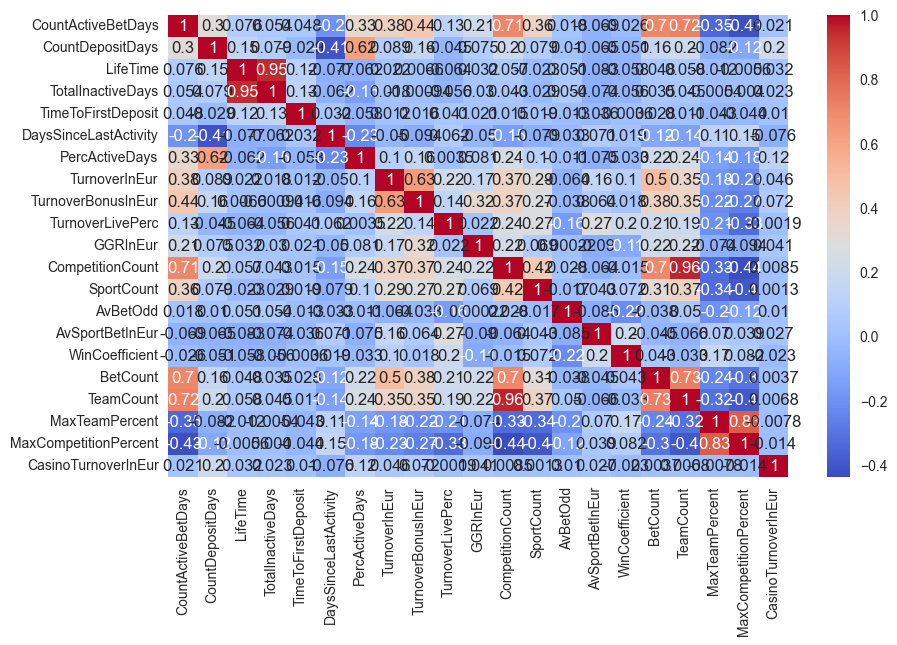

In [55]:
plot_feature_correlations(data)

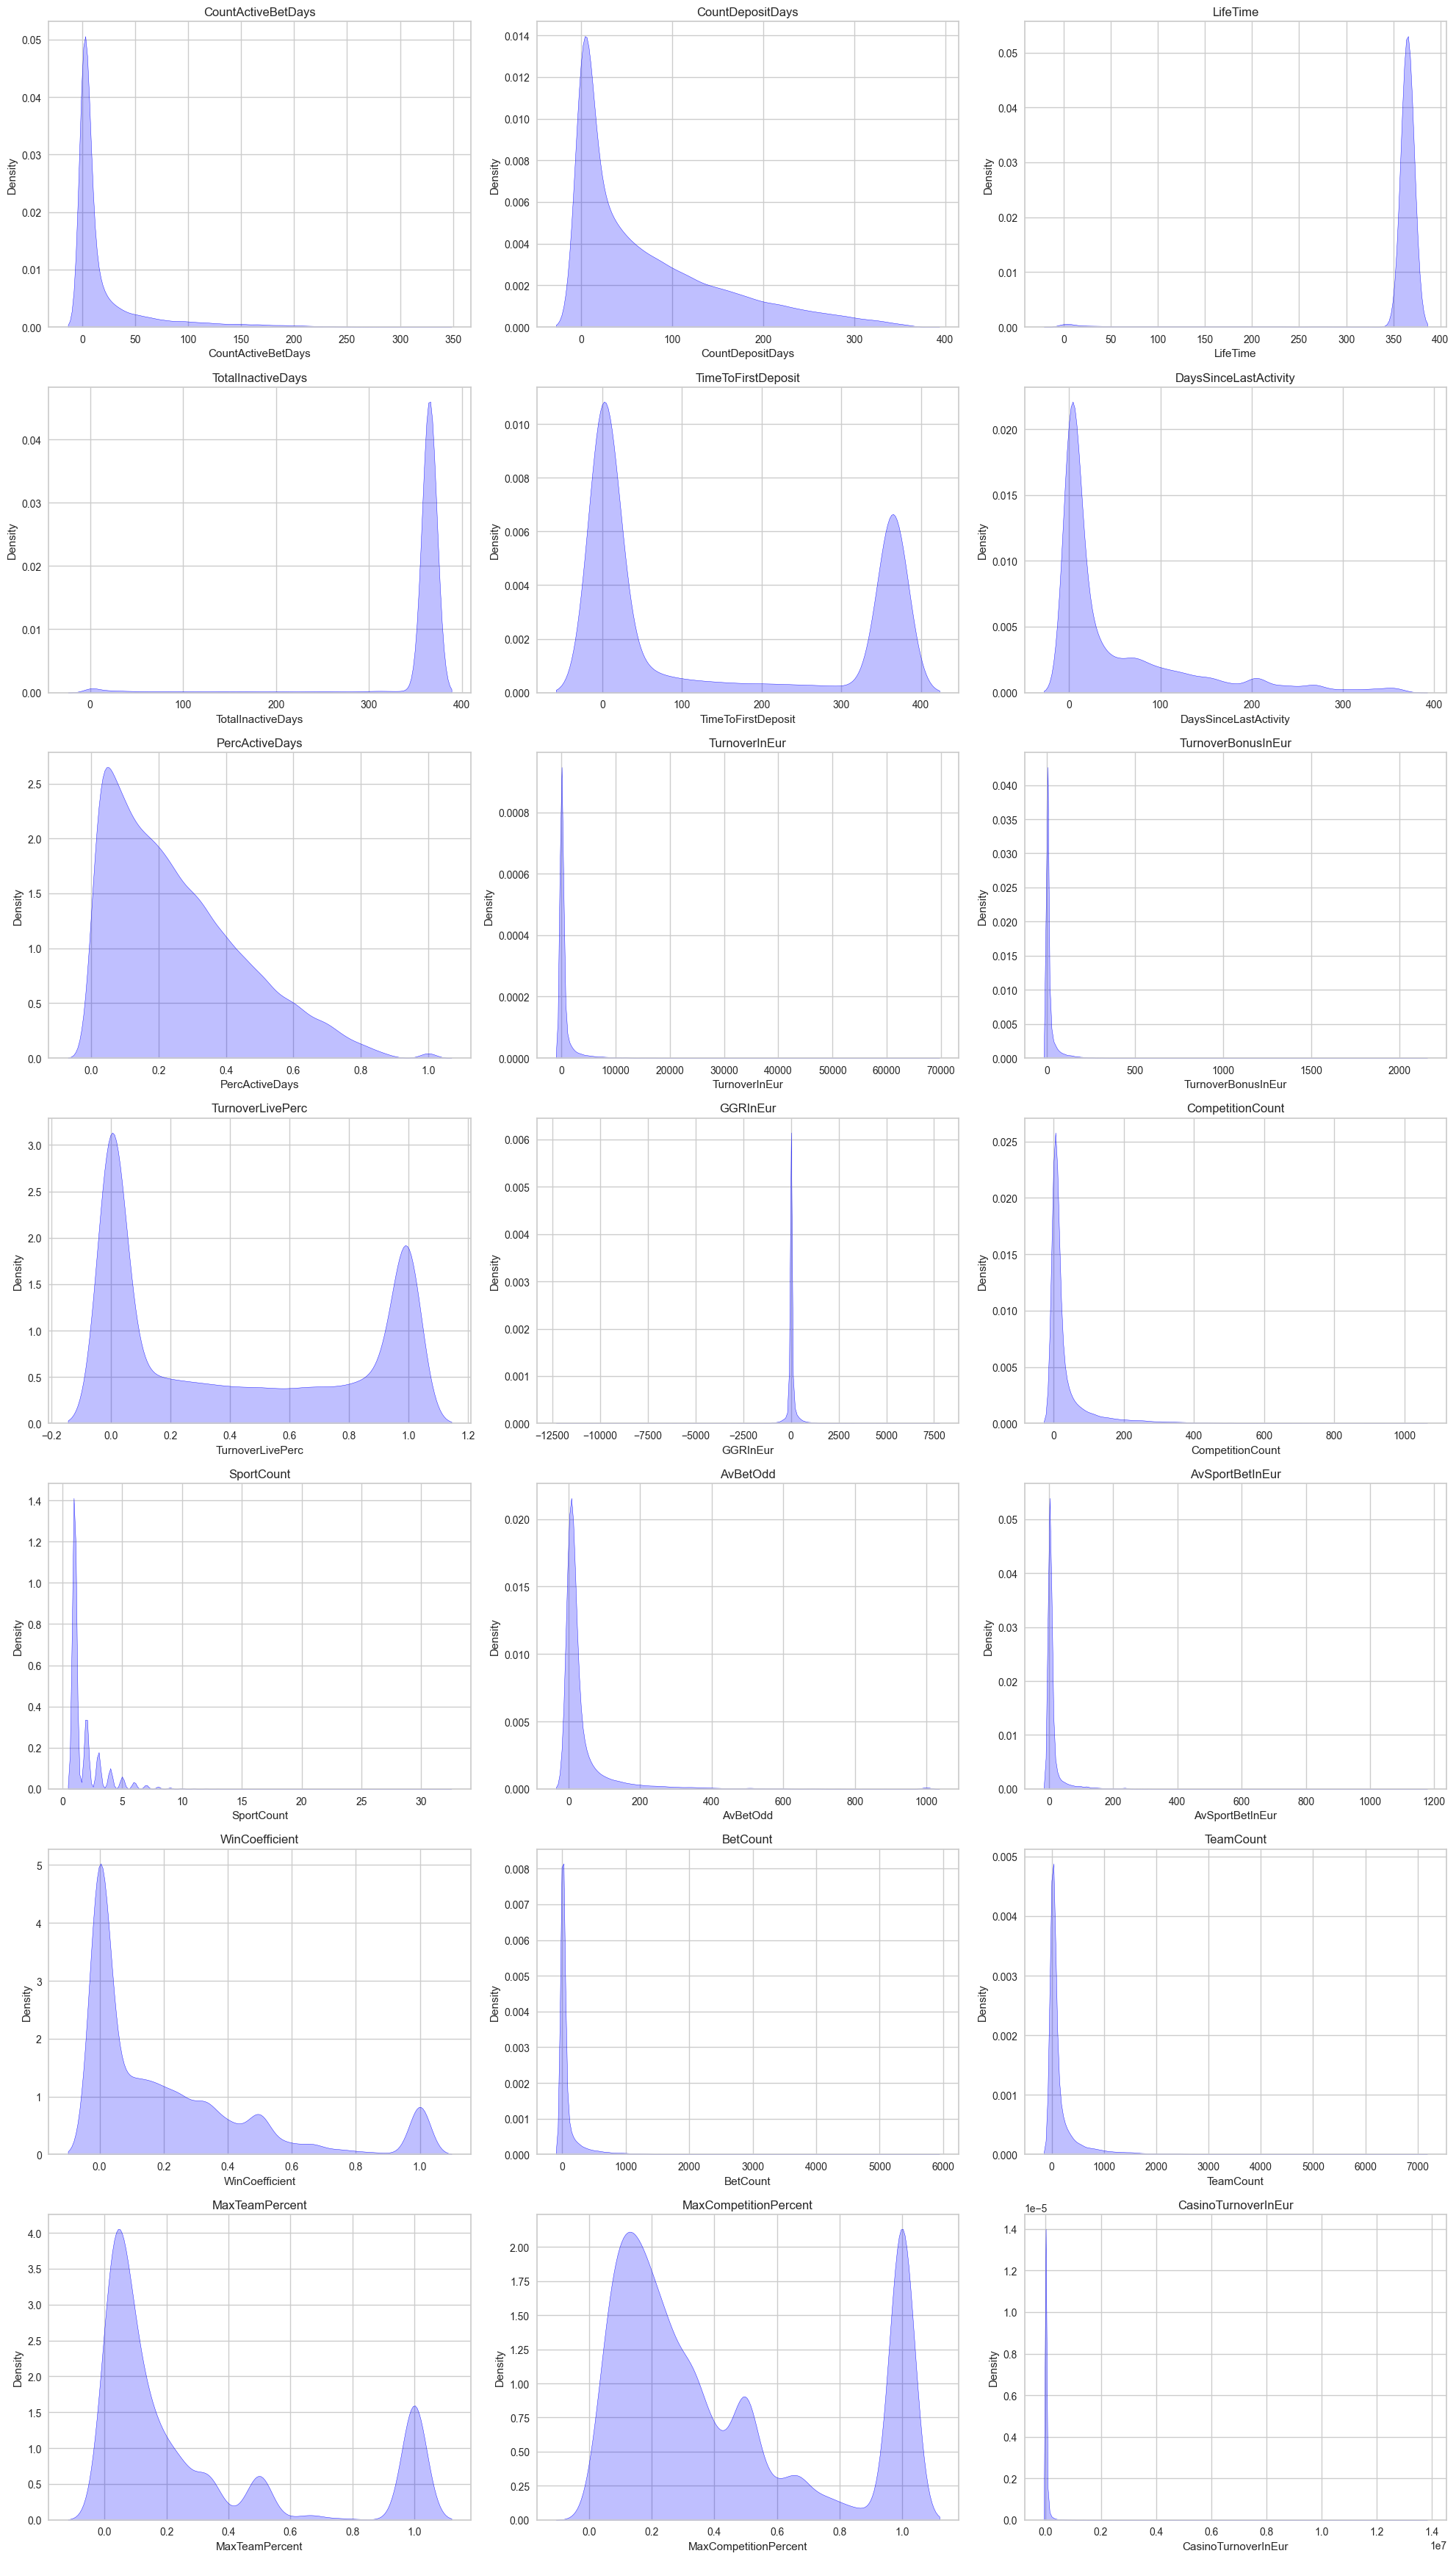

In [56]:
plot_feature_distributions(data)

In [57]:
# Binned features analysis
create_interactive_pie_charts(data, num_bins=10)

### Data insights
*Note: features that described days are changed to have a range between 0 and 365*

- 29% of users won more than they lost
- 82.4% of users have up to 34 active days per year
- 47.4% of users have up to 37 days with deposits per year (it means that 47.4% of users have money only on activity days)
- 92.4% of users have from 329 to 365 inactive days per year
- 55% of users have up to 36 days before their first deposit
- 95.7% of users have up to 585 bets per year
- 93.8% of users have up to 4 sport type of bets  
- 97% of users have an average sports bet of up to 116 EUR

### Clustering

In [58]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
pca = PCA(n_components=scaled_data.shape[1])
pca.fit(scaled_data)

PCA(n_components=21)

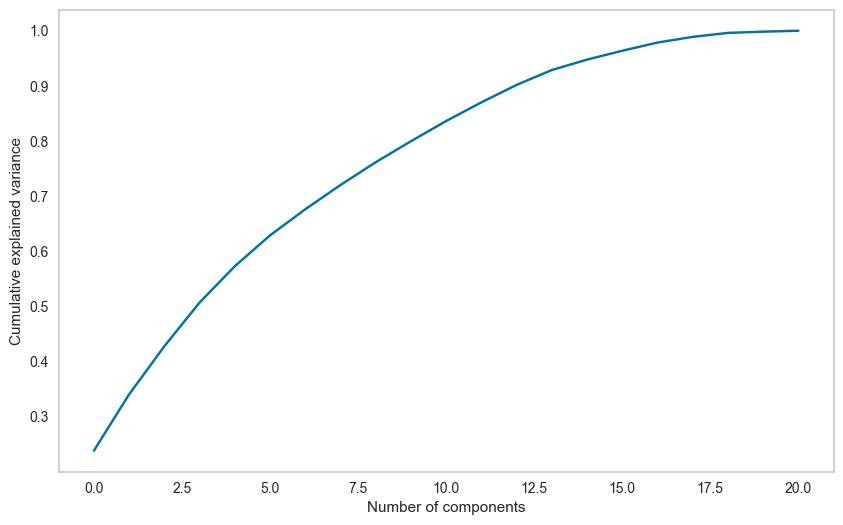

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid()
plt.show()

Number of components for 0.8 explained variance: 11


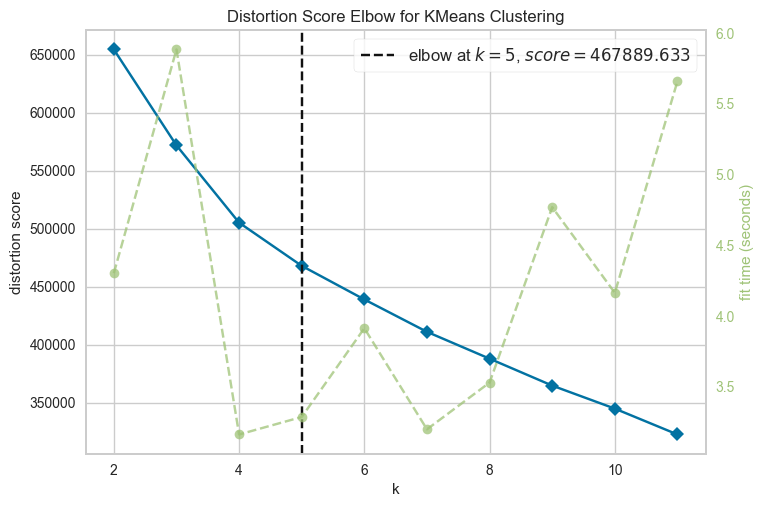

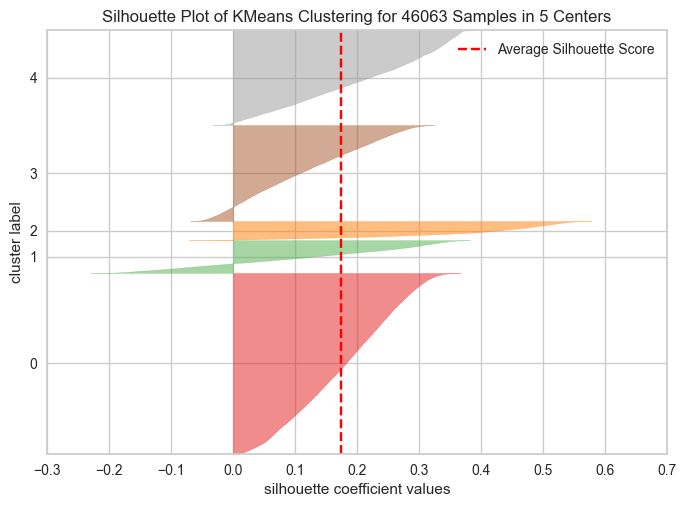

Silhouette score: 0.17409013039976
Calinski-Harabasz score: 8391.954350561888
Davies-Bouldin score: 1.592312142904516

Number of components for 0.9 explained variance: 13


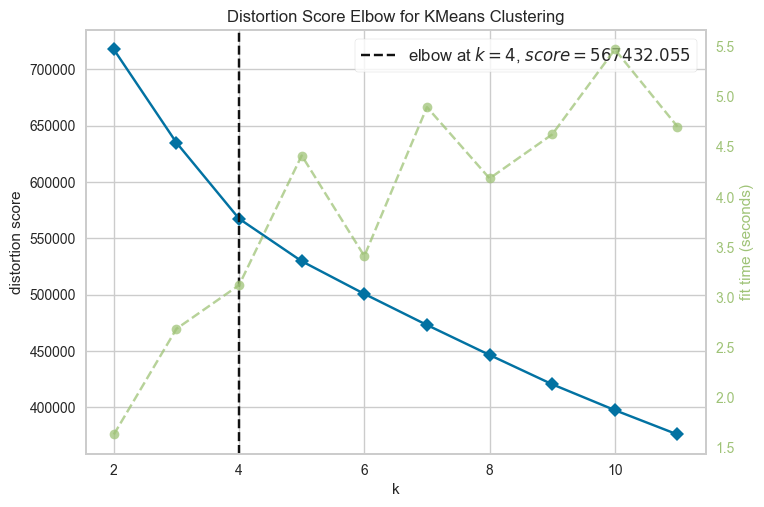

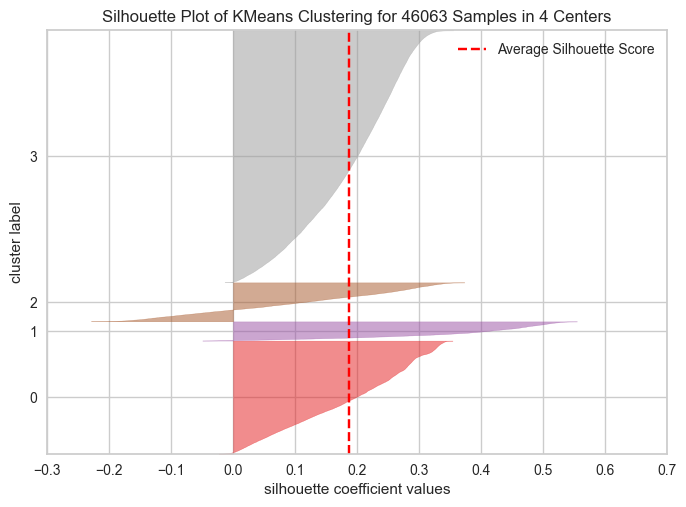

Silhouette score: 0.1866190256549576
Calinski-Harabasz score: 8247.566576259762
Davies-Bouldin score: 1.5580963398722423



In [60]:
n_components_list = [0.8, 0.9]
n_clusters_list = list()
silhouette, calinski, davies = list(), list(), list()
for n_components in n_components_list:
    pca = PCA(n_components=n_components)
    X = pca.fit_transform(scaled_data)
    print(f"Number of components for {n_components} explained variance: {pca.n_components_}")
    kmeans = KMeans(n_init=30, max_iter=1000)
    visualizer_1 = kelbow_visualizer(kmeans, X, k=(2, 12))
    kmeans = KMeans(n_clusters=visualizer_1.elbow_value_, n_init=30, max_iter=1000)
    visualizer_2 = silhouette_visualizer(kmeans, X)
    labels = kmeans.fit_predict(X)
    n_clusters_list.append(visualizer_1.elbow_value_)
    print(f"Silhouette score: {silhouette_score(X, labels)}")
    print(f"Calinski-Harabasz score: {calinski_harabasz_score(X, labels)}")
    print(f"Davies-Bouldin score: {davies_bouldin_score(X, labels)}\n")

n_clusters_list = np.unique(n_clusters_list).tolist()

In [61]:
# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    n_components = trial.suggest_categorical("pca__n_components", n_components_list)
    n_clusters = trial.suggest_categorical("kmeans__n_clusters", n_clusters_list)
    n_init = trial.suggest_categorical("kmeans__n_init", [10, 20, 30])
    max_iter = trial.suggest_categorical("kmeans__max_iter", [300, 500, 1000])
    
    # Preprocessing pipeline
    preprocessing = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=n_components))
    ])
    
    # Create pipeline
    pipe = Pipeline([
        ("preprocessing", preprocessing),
        ("clusterer", KMeans(
            n_clusters=n_clusters,
            n_init=n_init,
            max_iter=max_iter
        ))
    ])

    pipe.fit(data)

    return silhouette_score(pipe.named_steps["preprocessing"].transform(data), pipe.named_steps["clusterer"].labels_)

search_space = {
    "pca__n_components": n_components_list,
    "kmeans__n_clusters": n_clusters_list,
    "kmeans__n_init": [10, 20, 30],
    "kmeans__max_iter": [300, 500, 1000]
}

# Create a study for grid search
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.GridSampler(search_space))
n_experiments = np.prod([len(v) for v in search_space.values()])
print(f"Number of experiments: {n_experiments}")
study.optimize(objective, n_trials=n_experiments)
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=10)

# Print the best parameters
print("Best parameters found: ", study.best_params)
print("Best Silhouette Score score: ", study.best_value)

[I 2024-07-21 22:19:57,398] A new study created in memory with name: no-name-5df4f11c-e76e-4623-87b7-3ff1a74806a1


Number of experiments: 36


[I 2024-07-21 22:20:14,267] Trial 0 finished with value: 0.15943013169391002 and parameters: {'pca__n_components': 0.9, 'kmeans__n_clusters': 5, 'kmeans__n_init': 10, 'kmeans__max_iter': 500}. Best is trial 0 with value: 0.15943013169391002.
[I 2024-07-21 22:20:31,341] Trial 1 finished with value: 0.1864883211054241 and parameters: {'pca__n_components': 0.9, 'kmeans__n_clusters': 4, 'kmeans__n_init': 10, 'kmeans__max_iter': 500}. Best is trial 1 with value: 0.1864883211054241.
[I 2024-07-21 22:20:50,002] Trial 2 finished with value: 0.19988879201171428 and parameters: {'pca__n_components': 0.8, 'kmeans__n_clusters': 4, 'kmeans__n_init': 30, 'kmeans__max_iter': 500}. Best is trial 2 with value: 0.19988879201171428.
[I 2024-07-21 22:21:07,723] Trial 3 finished with value: 0.1865067326314962 and parameters: {'pca__n_components': 0.9, 'kmeans__n_clusters': 4, 'kmeans__n_init': 20, 'kmeans__max_iter': 1000}. Best is trial 2 with value: 0.19988879201171428.
[I 2024-07-21 22:21:26,078] Trial 

Best parameters found:  {'pca__n_components': 0.8, 'kmeans__n_clusters': 4, 'kmeans__n_init': 30, 'kmeans__max_iter': 1000}
Best Silhouette Score score:  0.2002069950346371


In [62]:
pca = PCA(n_components=study.best_params["pca__n_components"])
X = pca.fit_transform(scaled_data)

kmeans = KMeans(
    n_clusters=study.best_params["kmeans__n_clusters"],
    n_init=study.best_params["kmeans__n_init"],
    max_iter=study.best_params["kmeans__max_iter"]
)

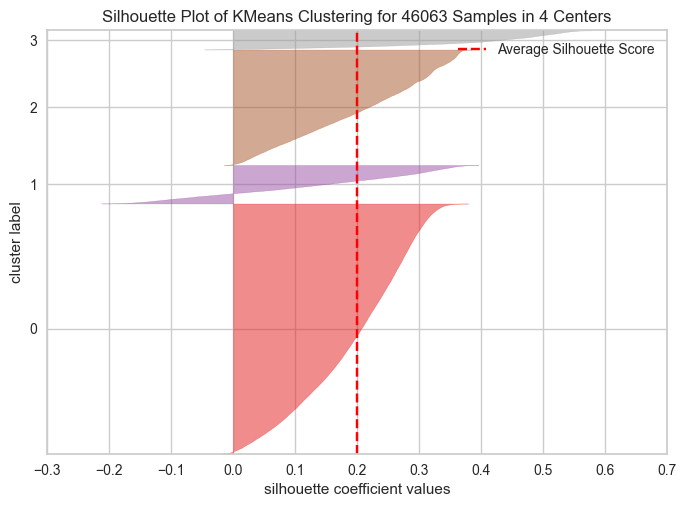

In [63]:
visualizer_2 = silhouette_visualizer(kmeans, X)

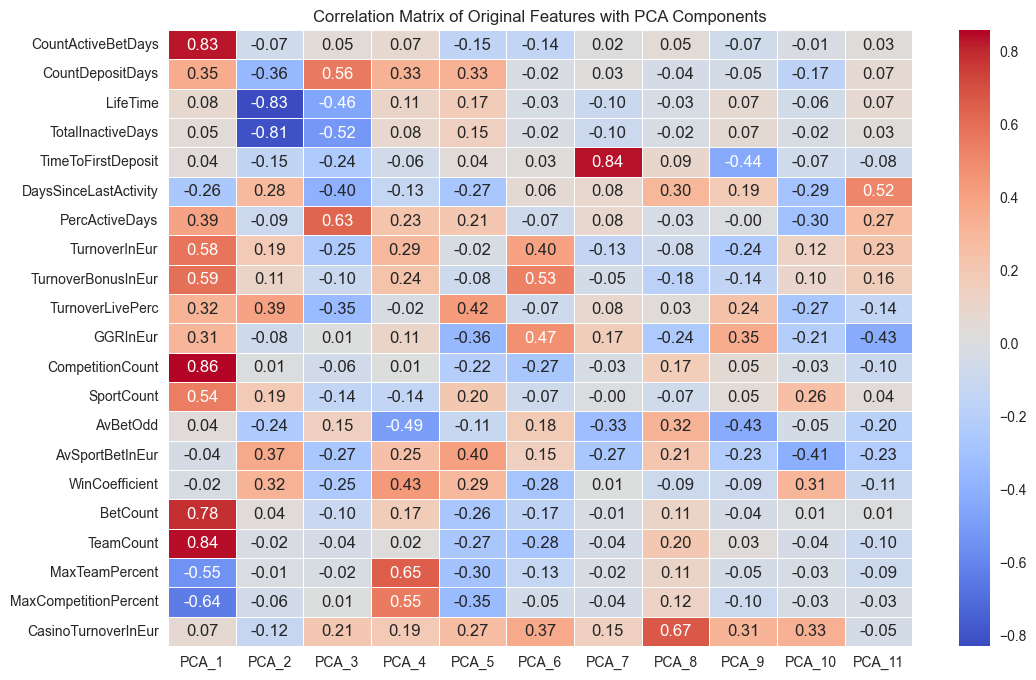

In [64]:
# Example creation of DataFrame for demonstration
pca_components = pd.DataFrame(X)

# Rename PCA components to PCA_1, PCA_2, etc.
pca_components.columns = [f'PCA_{i+1}' for i in range(pca_components.shape[1])]

# Initialize an empty DataFrame to store correlations
correlation_matrix = pd.DataFrame(index=data.columns, columns=pca_components.columns)

# Calculate correlations between each feature and each component
for feature_column in data.columns:
    for pca_column in pca_components.columns:
        correlation_matrix.loc[feature_column, pca_column] = np.corrcoef(data[feature_column], pca_components[pca_column])[0, 1]

# Convert data to numeric format
correlation_matrix = correlation_matrix.astype(float)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Original Features with PCA Components')
plt.show()

In [65]:
# Preprocessing pipeline
preprocessing = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=study.best_params["pca__n_components"]))
])

# Create pipeline
pipe = Pipeline([
    ("preprocessing", preprocessing),
    ("clusterer", KMeans(
        n_clusters=study.best_params["kmeans__n_clusters"],
        n_init=study.best_params["kmeans__n_init"],
        max_iter=study.best_params["kmeans__max_iter"]
    ))
])

In [66]:
pipe.fit(data)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('pca', PCA(n_components=0.8))])),
                ('clusterer', KMeans(max_iter=1000, n_clusters=4, n_init=30))])